In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testdf = pd.read_csv('test.csv')

Trained on the dataset which file_length > 200

In [180]:
model_path = '1709-may25'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics)

{   'args': {   '--batch-size': '128',
                '--clip-grad': '5.0',
                '--dropout': '0.1',
                '--embed-size': '1028',
                '--help': False,
                '--hidden-size': '256',
                '--load': False,
                '--load-from': 'default-model',
                '--log-every': '10',
                '--lr': '0.0003',
                '--max-epoch': '30',
                '--max-sent-len': '10000',
                '--n-heads': '4',
                '--n-layers': '2',
                '--n-valid': '2000',
                '--n-words': '2000',
                '--qtest': False,
                '--save': True,
                '--save-to': '1709-may25',
                '--seed': '0',
                '--valid-niter': '40',
                '--validate-every': '30'},
    'total_time': 297.271,
    'train_acc': [   0.4609375,
                     0.671875,
                     0.5390625,
                     0.828125,
                     0.6

Total Time: 297.271 
Train Time: 64.352


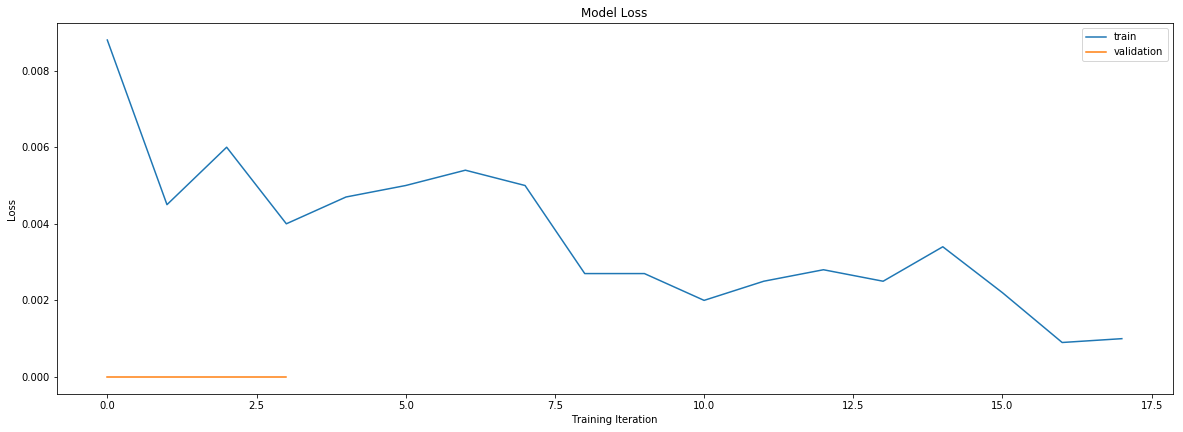

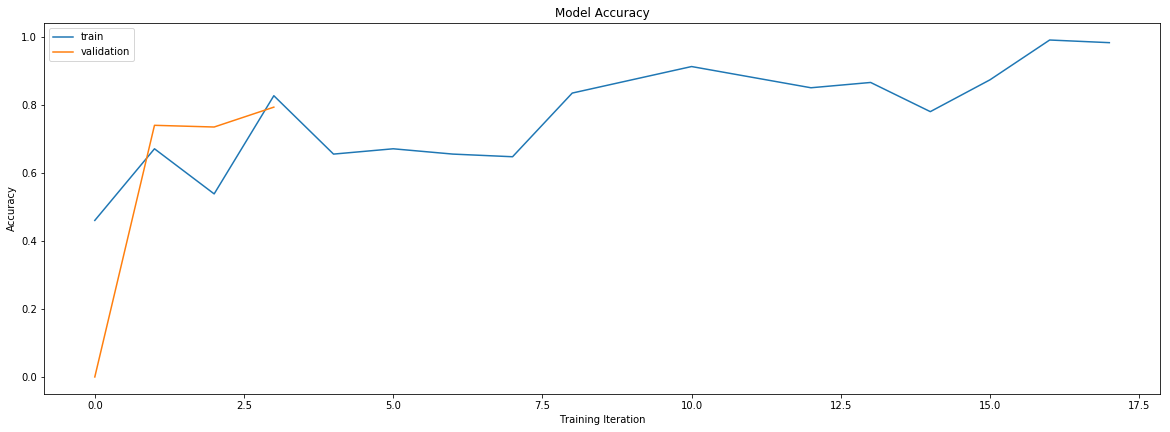

In [4]:
def format_sent(sentence):
    formatted_sentence = ['<start>', '0']
    idxs = list(range(1, len(sentence)+1))
    for (w, i) in list(zip(sentence, idxs)):
        formatted_sentence.append(w)
        formatted_sentence.append(str(i))
    formatted_sentence.append('<end>')
    formatted_sentence.append(str(len(idxs)+1))
    
    return ' '.join(formatted_sentence)

def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    figsize = (20, 15)
    plt.figure(1, figsize=figsize)                
    plt.subplot(211)
    plt.plot(metrics['itr'], metrics['train_loss'],  label='train')
    plt.plot(metrics['val_itr'], metrics['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    # plot accuracy
    plt.figure(2, figsize=figsize)                # a second figure
    plt.subplot(212)
    plt.plot(metrics['itr'], metrics['train_acc'], label='train')
    plt.plot(metrics['val_itr'], metrics['val_acc'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    
    plt.show()
    
plot_metrics(metrics)

In [171]:
# Thanks to, 
# https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
def plot_sentence_attention(sentence, batch_idx=None, target='N/A', attention_layer=0, n=5):
    
    model.eval()
    # Hook the Attention Weights
    attentions = model._modules.get('attentions')
    tracked_attention_weigths = []
    def show(m, i, o): 
        _, w = o
        tracked_attention_weigths.append(w)
    hook = attentions[0].register_forward_hook(show)
    hook2 = attentions[1].register_forward_hook(show)
    
    # get attention weights
    x = [sentence] if batch_idx == None else sentence
    y = target if batch_idx == None else target[batch_idx]
    
    h_x = model(x)
    pred_y = h_x if batch_idx == None else h_x[batch_idx]
    pred_y = pred_y.detach().numpy().squeeze()
    
    print("Predicted Value: %.2f True Value: %.2f" % (pred_y, y))
    hook.remove()
    w = tracked_attention_weigths[0]
    w2 = tracked_attention_weigths[1]
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True)
    
    attention = w.detach().numpy().squeeze()
    attention = attention if batch_idx == None else attention[batch_idx]
    
    attention2 = w2.detach().numpy().squeeze()
    attention2 = attention2 if batch_idx == None else attention2[batch_idx]
    
    axs[0].matshow(attention, cmap='viridis')
    axs[1].matshow(attention2, cmap='viridis')
    
    fontdict = {'fontsize': 14}

#     ax.set_title("{}-Layer Long-Sentence Attention".format(attention_layer))
#     print("{}-Layer Long-Sentence Attention".format(attention_layer))
    
    words = sentence if batch_idx == None else sentence[batch_idx]
    # filter through language model for <unk> tokens
    words = [lang.id2word[d] for d in [lang.get_id(w) for w in sentence]]
    
#     if len(words) < 50: 
    axs[0].set_xticklabels([''] + ['<start>'] + words + ['<end>'], fontdict=fontdict, rotation=90)
    axs[0].set_yticklabels([''] + ['<start>'] + words + ['<end>'], fontdict=fontdict)
    axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    axs[1].set_xticklabels([''] + ['<start>'] + words + ['<end>'], fontdict=fontdict, rotation=90)
    axs[1].set_yticklabels([''] + ['<start>'] + words + ['<end>'], fontdict=fontdict)
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1].yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
#     print("{} Most Paid Attention Too Words".format(n))
#     ind = np.argpartition(np.sum(attention, axis=0), -n)[-n:]
#     print("\n".join(["{} - {} : {}".format(i, words[i], ' '.join(words[max(0, i-5):min(i+5, len(words))])) for i in ind]))
#     print()
    
#     print("{} Words Which Attended To The Most Words".format(n))
#     ind = np.argpartition(np.sum(attention, axis=1), -n)[-n:]
#     print("\n".join(["{} - {} : {}".format(i, words[i], ' '.join(words[max(0, i-5):min(i+5, len(words))])) for i in ind]))
    
    return attention, format_sent(words)

In [60]:
# Sample Example from dataset
df = testdf[testdf.file_length > 100]
for sents, targets in batch_iter(lang, df, 5, shuffle=True):
    break

Predicted Value: 0.90 True Value: 1.00


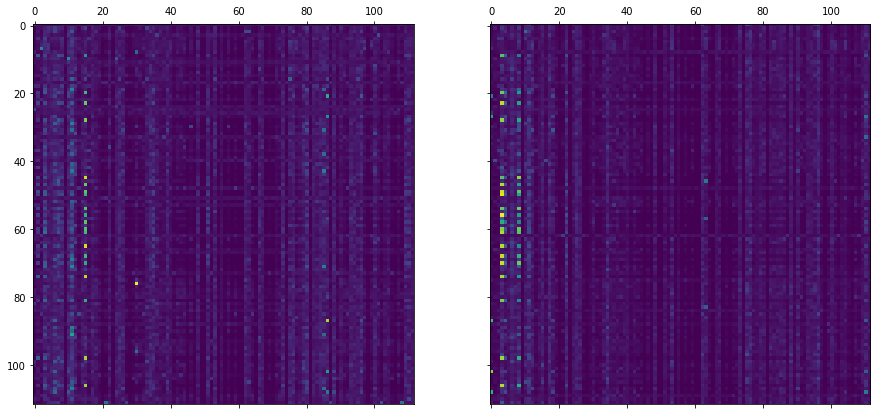

5 Most Paid Attention Too Words
7 - wonder : and i love it ! ! ! wonder showzen will pick up a cult audience and once
6 - ! : and i love it ! ! ! wonder showzen will pick up a cult audience and
3 - it : and i love it ! ! ! wonder showzen will pick up a
11 - up : i love it ! ! ! wonder showzen will pick up a cult audience and once it is canceled the
15 - and : ! ! wonder showzen will pick up a cult audience and once it is canceled the dvd sales will go

5 Words Which Attended To The Most Words
43 - a : own ways . it is a parody of childrens shows
47 - shows : is a parody of childrens shows namely sesame street .
44 - parody : ways . it is a parody of childrens shows namely
45 - of : . it is a parody of childrens shows namely sesame
99 - himself : like thing that refers to himself in the third person


'<start> 0 and 1 i 2 love 3 it 4 ! 5 ! 6 ! 7 wonder 8 showzen 9 will 10 pick 11 up 12 a 13 cult 14 audience 15 and 16 once 17 it 18 is 19 canceled 20 the 21 dvd 22 sales 23 will 24 go 25 though 26 the 27 roof 28 . 29 this 30 is 31 a 32 very 33 funny 34 show 35 in 36 it 37 is 38 own 39 ways 40 . 41 it 42 is 43 a 44 parody 45 of 46 childrens 47 shows 48 namely 49 sesame 50 street 51 . 52 our 53 puppet 54 characters 55 consist 56 of 57 chauncy 58 a 59 yellow 60 furry 61 monster 62 with 63 a 64 hat 65 whose 66 our 67 host 68 . 69 clarence 70 is 71 a 72 blue 73 lizard 74 like 75 thing 76 that 77 does 78 his 79 own 80 segments 81 where 82 he 83 goes 84 out 85 on 86 the 87 streets 88 . 89 him 90 is 91 a 92 weird 93 dog 94 like 95 thing 96 that 97 refers 98 to 99 himself 100 in 101 the 102 third 103 person 104 . 105 wordsworth 106 is 107 the 108 smart 109 one 110 <end> 111'

In [118]:
batch_idx = 0
for sents, targets in batch_iter(lang, df, 2, shuffle=True):
    break
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)
s

Predicted Value: 0.51 True Value: 0.00


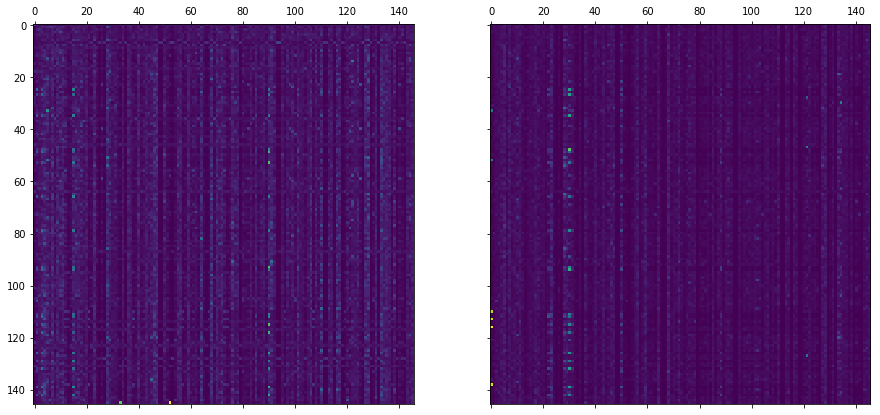

5 Most Paid Attention Too Words
133 - are : he is dwarfed by richard harris and gene hackman they are both actors . no eastwood is a tall guy
28 - some : in fact . i know that unforgiven is ranked by some as one of the greatest westerns ever made .
128 - harris : . in this film alone he is dwarfed by richard harris and gene hackman they are both actors . no
90 - do : that is clearly a matter of taste but i also do not admire eastwoods acting . he is not and
15 - not : of view i did not like it . i did not finish it in fact . i know that unforgiven

5 Words Which Attended To The Most Words
2 - for : and now for another point of view
113 - paul : is no burt lancaster no paul newman no john wayne
88 - i : a matter of taste but i also do not admire
98 - not : eastwoods acting . he is not and never has been
55 - cinema : of the icons of american cinema . i know that


'<start> 0 and 1 now 2 for 3 another 4 point 5 of 6 view 7 i 8 did 9 not 10 like 11 it 12 . 13 i 14 did 15 not 16 finish 17 it 18 in 19 fact 20 . 21 i 22 know 23 that 24 unforgiven 25 is 26 ranked 27 by 28 some 29 as 30 one 31 of 32 the 33 greatest 34 westerns 35 ever 36 made 37 . 38 i 39 know 40 that 41 it 42 stars 43 and 44 was 45 directed 46 by 47 clint 48 eastwood 49 one 50 of 51 the 52 icons 53 of 54 american 55 cinema 56 . 57 i 58 know 59 that 60 it 61 won 62 a 63 bunch 64 of 65 oscars 66 . 67 still 68 i 69 did 70 not 71 like 72 it 73 . 74 i 75 do 76 not 77 like 78 westerns 79 and 80 that 81 is 82 clearly 83 a 84 matter 85 of 86 taste 87 but 88 i 89 also 90 do 91 not 92 admire 93 eastwoods 94 acting 95 . 96 he 97 is 98 not 99 and 100 never 101 has 102 been 103 a 104 leading 105 man 106 . 107 he 108 is 109 no 110 burt 111 lancaster 112 no 113 paul 114 newman 115 no 116 john 117 wayne 118 . 119 in 120 this 121 film 122 alone 123 he 124 is 125 dwarfed 126 by 127 richard 128 harris 1

In [119]:
batch_idx = 0
for sents, targets in batch_iter(lang, df, 2, shuffle=True):
    break
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)
s

Predicted Value: 0.13 True Value: 1.00


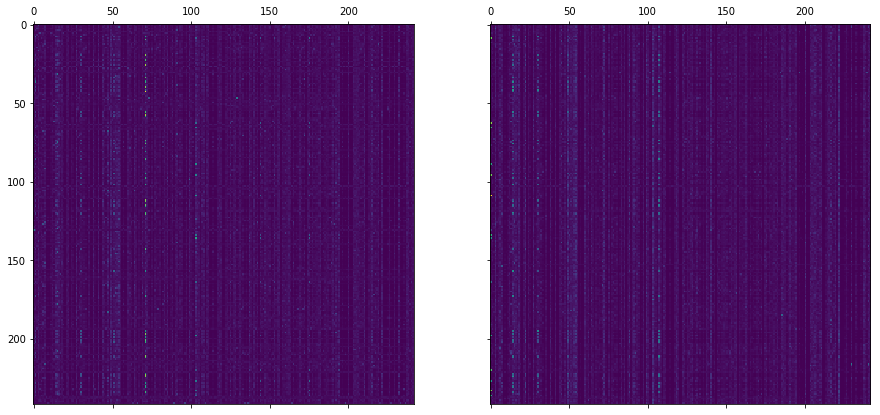

5 Most Paid Attention Too Words
54 - pure : with a camera . ultimately it comes out somewhere between pure brilliance and unwatchability thankfully much more so the former
49 - it : junkies self indulgently fooling around with a camera . ultimately it comes out somewhere between pure brilliance and unwatchability thankfully
15 - cinema : this film defines the essence of everything i love about cinema in terms of capturing those strange elusive moments of
103 - production : completely ignore the occasionally downright awful acting and overtly bad production values . at first the editing seems overwhelmingly sloppy
71 - wants : so the former than the latter . part of me wants to reward it solely for it is absolute innovativeness

5 Words Which Attended To The Most Words
64 - than : much more so the former than the latter . part
112 - sloppy : first the editing seems overwhelmingly sloppy and needlessly distracting or
115 - distracting : seems overwhelmingly sloppy and needlessly distract

'<start> 0 in 1 a 2 lot 3 of 4 ways 5 this 6 film 7 defines 8 the 9 essence 10 of 11 everything 12 i 13 love 14 about 15 cinema 16 in 17 terms 18 of 19 capturing 20 those 21 strange 22 elusive 23 moments 24 of 25 unguarded 26 truth 27 . 28 in 29 other 30 ways 31 it 32 is 33 undeniably 34 an 35 amateurish 36 unfocused 37 result 38 of 39 junkies 40 self 41 indulgently 42 fooling 43 around 44 with 45 a 46 camera 47 . 48 ultimately 49 it 50 comes 51 out 52 somewhere 53 between 54 pure 55 brilliance 56 and 57 unwatchability 58 thankfully 59 much 60 more 61 so 62 the 63 former 64 than 65 the 66 latter 67 . 68 part 69 of 70 me 71 wants 72 to 73 reward 74 it 75 solely 76 for 77 it 78 is 79 absolute 80 innovativeness 81 and 82 moments 83 of 84 pure 85 sublimity 86 but 87 at 88 the 89 same 90 time 91 i 92 cannot 93 completely 94 ignore 95 the 96 occasionally 97 downright 98 awful 99 acting 100 and 101 overtly 102 bad 103 production 104 values 105 . 106 at 107 first 108 the 109 editing 110 seems 

In [121]:
batch_idx = 0
for sents, targets in batch_iter(lang, df, 2, shuffle=True):
    break
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)
s

Predicted Value: 0.67 True Value: 1.00


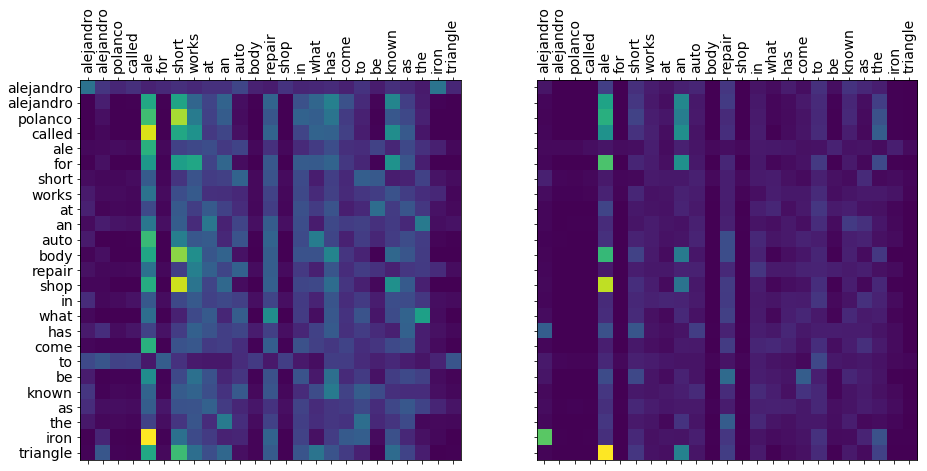

5 Most Paid Attention Too Words
75 - their : able to receive such large discounts they simply put down their cash and hope that everything is on the up
6 - short : alejandro alejandro polanco called ale for short works at an auto body repair shop in what
79 - that : large discounts they simply put down their cash and hope that everything is on the up and up . sleazy
4 - ale : alejandro alejandro polanco called ale for short works at an auto body repair shop
47 - . : repair dealers close to shea stadium in queens new york . here customers do not question whether or not parts

5 Words Which Attended To The Most Words
135 - man : follow up to his acclaimed man push cart bahrani spent
14 - in : an auto body repair shop in what has come to
141 - and : push cart bahrani spent one and a half years in
108 - vivid : ramin bahrani puts them on vivid display in chop shop
0 - alejandro : alejandro alejandro polanco called ale


'<start> 0 alejandro 1 alejandro 2 polanco 3 called 4 ale 5 for 6 short 7 works 8 at 9 an 10 auto 11 body 12 repair 13 shop 14 in 15 what 16 has 17 come 18 to 19 be 20 known 21 as 22 the 23 iron 24 triangle 25 a 26 deteriorating 27 twenty 28 block 29 stretch 30 of 31 auto 32 junk 33 yards 34 and 35 sleazy 36 car 37 repair 38 dealers 39 close 40 to 41 shea 42 stadium 43 in 44 queens 45 new 46 york 47 . 48 here 49 customers 50 do 51 not 52 question 53 whether 54 or 55 not 56 parts 57 come 58 from 59 stolen 60 cars 61 or 62 why 63 they 64 are 65 able 66 to 67 receive 68 such 69 large 70 discounts 71 they 72 simply 73 put 74 down 75 their 76 cash 77 and 78 hope 79 that 80 everything 81 is 82 on 83 the 84 up 85 and 86 up 87 . 88 sleazy 89 outskirts 90 like 91 these 92 are 93 not 94 highlighted 95 in 96 the 97 tour 98 guides 99 but 100 iranian 101 american 102 director 103 ramin 104 bahrani 105 puts 106 them 107 on 108 vivid 109 display 110 in 111 chop 112 shop 113 a 114 powerful 115 indie 1

In [125]:
batch_idx = 0
for sents, targets in batch_iter(lang, df, 2, shuffle=True):
    break
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)
s

Attention is payed to frequent words 

Predicted Value: 0.00 True Value: 0.00


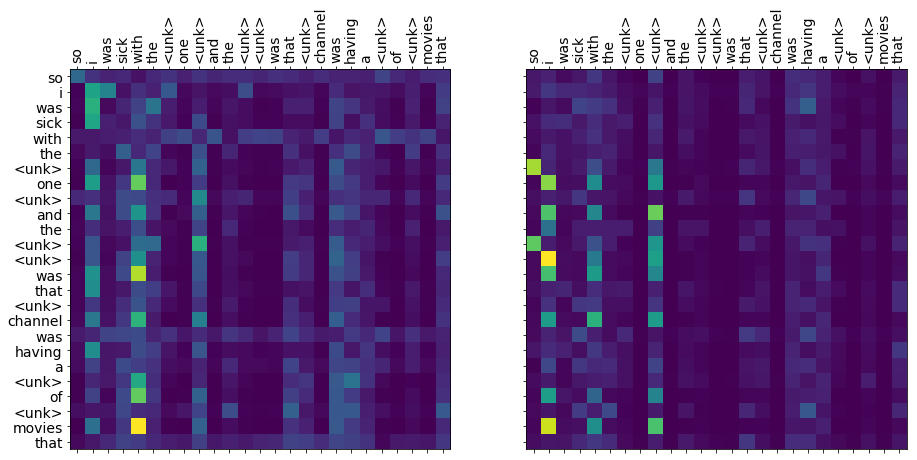

5 Most Paid Attention Too Words
109 - it : that looks almost exactly like a scene in <unk> except it was in the middle of that movie . then
4 - with : so i was sick with the <unk> one <unk> and the <unk> <unk> was
38 - my : <unk> <unk> <unk> island . then i <unk> ahead on my cable <unk> to see which movie <unk> <unk> in
222 - movie : plot and tried to pass it off as an original movie . <unk> . i do not know who i
125 - acting : that movie . then i sat through some really bad acting and then some guy was <unk> into walking into

5 Words Which Attended To The Most Words
107 - <unk> : exactly like a scene in <unk> except it was in
170 - <unk> : after i saw some scenes <unk> <unk> off from <unk>
231 - i : i do not know who i am more angry at
46 - <unk> : to see which movie <unk> <unk> in its <unk> <unk>
251 - <unk> : off as worthy of the <unk> time <unk> . the


'<start> 0 so 1 i 2 was 3 sick 4 with 5 the 6 <unk> 7 one 8 <unk> 9 and 10 the 11 <unk> 12 <unk> 13 was 14 that 15 <unk> 16 channel 17 was 18 having 19 a 20 <unk> 21 of 22 <unk> 23 movies 24 that 25 day 26 the 27 <unk> 28 <unk> 29 <unk> 30 <unk> 31 island 32 . 33 then 34 i 35 <unk> 36 ahead 37 on 38 my 39 cable 40 <unk> 41 to 42 see 43 which 44 movie 45 <unk> 46 <unk> 47 in 48 its 49 <unk> 50 <unk> 51 <unk> 52 time 53 <unk> 54 . 55 some 56 movie 57 i 58 had 59 never 60 heard 61 of 62 before 63 called 64 <unk> 65 . 66 i 67 was 68 pretty 69 <unk> 70 . 71 the 72 movie 73 begins 74 with 75 some 76 <unk> 77 driving 78 around 79 in 80 a 81 <unk> 82 when 83 they 84 get 85 <unk> 86 and 87 killed 88 by 89 a 90 <unk> 91 . 92 i 93 was 94 like 95 <unk> 96 that 97 is 98 odd 99 that 100 looks 101 almost 102 exactly 103 like 104 a 105 scene 106 in 107 <unk> 108 except 109 it 110 was 111 in 112 the 113 middle 114 of 115 that 116 movie 117 . 118 then 119 i 120 sat 121 through 122 some 123 really 124 ba

In [146]:
batch_idx = 0
for sents, targets in batch_iter(lang, df, 2, shuffle=True):
    break
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)
s

Predicted Value: 0.69 True Value: 0.00


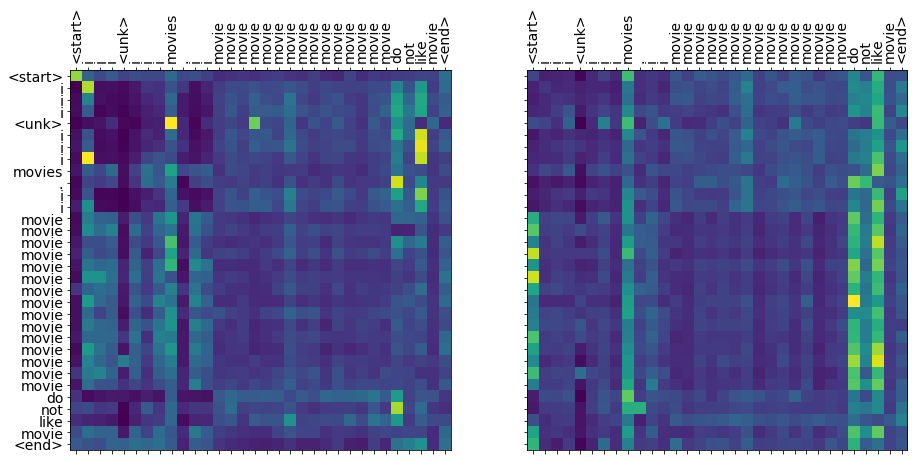

'<start> 0 i 1 i 2 i 3 <unk> 4 i 5 i 6 i 7 movies 8 . 9 i 10 i 11 movie 12 movie 13 movie 14 movie 15 movie 16 movie 17 movie 18 movie 19 movie 20 movie 21 movie 22 movie 23 movie 24 movie 25 movie 26 do 27 not 28 like 29 movie 30 <end> 31'

In [178]:
w, s = plot_sentence_attention(('i i i i. i i i movies . i i'.split(' ') + ['movie'] * 15 + ['do', 'not', 'like', 'movie']), 
                               batch_idx=None,
                               target=0)
s